<a href="https://colab.research.google.com/github/SaumilShah-7/Scene-Classification/blob/master/Scene_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import models, layers

2.0.0


In [6]:
from google.colab import files
files.upload()

Saving image_scene_data.zip to image_scene_data.zip


In [0]:
!unzip -q image_scene_data.zip
!rm -rf image_scene_data.zip

In [0]:

df = pd.DataFrame([file for file in os.listdir('original')], columns=['ImageId'])

y_json = pd.read_json('labels.json', lines=True)
y_label_vec = [np.asarray((row==1)*1) for index, row in y_json.iterrows()]

df['Labels_vec'] = df['ImageId'].map(lambda x: y_label_vec[int(str.split(x, '.')[0])-1].tolist())

label_names = ['desert', 'mountains', 'sea', 'sunset', 'trees']
df['Labels'] = df['Labels_vec'].map(lambda x: [label_names[i] for i, j in enumerate(x) if j==1])
df['Classnum'] = df['Labels'].map(lambda x: len(x))
df.head()

,ImageId,Labels_vec,Labels,Classnum
0,225.jpg,"[1, 0, 0, 0, 0]",[desert],1
1,363.jpg,"[1, 0, 0, 1, 0]","[desert, sunset]",2
2,1334.jpg,"[0, 0, 1, 1, 0]","[sea, sunset]",2
3,240.jpg,"[1, 0, 0, 0, 0]",[desert],1
4,1709.jpg,"[0, 0, 0, 0, 1]",[trees],1


{'desert': 409, 'mountains': 458, 'sea': 580, 'sunset': 465, 'trees': 560}


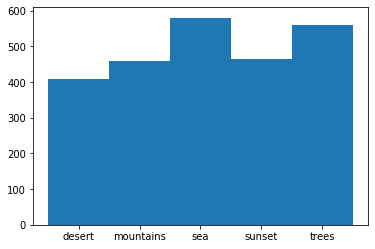

1    1543
2     442
3      15
Name: Classnum, dtype: int64


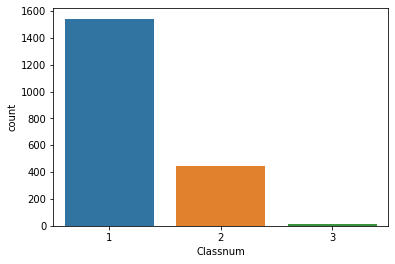

In [0]:
class_summary = np.asarray(y_label_vec).sum(axis=0).tolist()
class_count_dict = {label_names[i]: class_summary[i] for i in range(len(class_summary))}
print(class_count_dict)

xs = np.arange(len(label_names)) 
plt.bar(xs, class_summary, width=1, align='center')
plt.xticks(xs, label_names)
plt.show()

print(df['Classnum'].value_counts())
sns.countplot(df['Classnum'])

In [0]:
id = 7

from IPython.display import display

img = Image.open('original/'+df.loc[id, 'ImageId'])
display(img)
print(df.loc[id, 'ImageId'], df.loc[id, 'Labels'])

NameError: ignored

In [0]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=7, stratify=df['Classnum'])
print(train_df.shape, test_df.shape)

(1600, 4) (400, 4)


In [0]:
# x = []
# for files in df['ImageId']:
#   x.append(np.asarray(Image.open('original/'+files).resize((image_height, image_width))))
# x = np.asarray(x)

# y = np.asarray([i for i in df['Labels_vec']])

# print(x.shape, y.shape)

(2000, 224, 224, 3) (2000, 5)


In [0]:
image_height = 224
image_width = 224

bs =64
SEED = 7

train_aug_gen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, brightness_range=(0.9, 1.1), zoom_range=0.1, horizontal_flip=True, 
                               preprocessing_function=preprocess_input)

test_aug_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_aug_gen.flow_from_dataframe(train_df, directory='original', x_col='ImageId', y_col='Labels', 
                                        target_size=(image_height, image_width), class_mode='categorical', batch_size=bs, seed=SEED)

test_gen = test_aug_gen.flow_from_dataframe(test_df, directory='original', x_col='ImageId', y_col='Labels', 
                                        target_size=(image_height, image_width), class_mode='categorical', batch_size=test_df.shape[0])

# x_train, y_train = next(train_gen)
# x_test, y_test = next(test_gen)
# print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

# id = 16
# plt.imshow(x_train[id].astype(int))
# plt.show()
# y_train[id]

Found 1600 validated image filenames belonging to 5 classes.
Found 400 validated image filenames belonging to 5 classes.


In [0]:
model = models.Sequential()
model.add(ResNet50(include_top=False, weights='imagenet', input_shape=(image_height, image_width, 3)))
model.layers[0].trainable = False
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(units=100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=5, activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
batch_normalization_6 (Batch (None, 7, 7, 2048)        8192      
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 100)               10035300  
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                

In [0]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics='binary_accuracy')
